In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from helpers.plot_helpers import *
from helpers.computational_tools import *
from helpers.dynamic_model import dyn_model, dyn_model_SSD
%load_ext autoreload
%autoreload 3
import warnings
warnings.filterwarnings("ignore")

# Boundary problem
We have the following observations:
* The mixed model, which does not require determination of $C_R$, works well for all resolutions. Both, clipped GID procedure and clipped SSD procedure. They have accurate predictions of Smagorinsky coefficient for a range of resolution. The probable reason for this is that overshoot is found only in the leonard tensor at grid resolution. It could contribute to $l_j l_j$. However, there is no such term in the DMM model. The only terms are $(l_j-h_j)m_j$ and $m_jm_j$. If there are no overshoots in $m_j$ near the boundary, there is no way that boundary value can contribute to the prediceted Smagorinsky coefficient.
* We found that the SSD procedure applied to DMM-Reynolds model gives effectively the same prediction in a square and in the full domain apart from two highest resolutions. Based on this, we hypothesise that domain of averaging does not matter for the dynamic procedure and we can use as much data as possible as long as suprious overshoots near the boundary do not affect the prediction of $C_R$.
* Although GID procedure predicts negative $C_R$ and SSD procedure predicts negative $C_R$ at the highest resolution, their predicitons are very close square the square in a priori data and not trivial ($C_R\approx 20$) for the highest resolution.
* Based on these observations, we accept that it would be best to follow suggestion of Andrey Glazunov and perform averaging outside of the boundary away for a few point.
* Below we investigate the experiments with spurious prediction of $C_R$ in detail.
* Based on a priori analysis, when we do not perform clipping, the optimal Smagorinsky coefficient at the highest resolution for DMM and DMM-Reynolds models is below 0.01. This values is not compatible with numerics of MOM6. Thus, we consider only clipped versions of DMM models.
* That said, the only solution which requires investigation is SSD DMM-Reynolds model at the highest resolution in the upper layer, where prediction of $C_R$ is zero.
* Our strategy is plot every term of Germano decomposition and estimate optimal values of $C_S$ and $C_R$ square the box and for the full domain, for GID and SSD dynamic procedures.

In [74]:
prog = xr.open_dataset('/home/ctrsp-2024/pp2681/experiments/NeverWorld2/R4/Yankovsky23-0.3/output/snapshots_00029010.nc', decode_times=False).isel(time=slice(-1,None))
static = xr.open_dataset('/home/ctrsp-2024/pp2681/experiments/NeverWorld2/R4/Yankovsky23-0.3/output/ocean_geometry.nc', decode_times=False).rename({'lonh': 'xh', 'lonq': 'xq', 'lath': 'yh', 'latq': 'yq'})

In [75]:
dyn_GID_domain = dyn_model(prog.u, prog.v, static, ssm=True, reynolds=True, clip=True, Lat=(None,None), Lon=(None,None))
dyn_GID_square = dyn_model(prog.u, prog.v, static, ssm=True, reynolds=True, clip=True, Lon=(10,30), Lat=(30,50))

In [76]:
dyn_GIDh_domain = dyn_model(prog.u, prog.v, static, h=prog.h, ssm=True, reynolds=True, clip=True, Lat=(None,None), Lon=(None,None))
dyn_GIDh_square = dyn_model(prog.u, prog.v, static, h=prog.h, ssm=True, reynolds=True, clip=True, Lon=(10,30), Lat=(30,50))

In [77]:
dyn_SSD_domain = dyn_model_SSD(prog.u, prog.v, static, ssm=True, reynolds=True, clip=True, Lat=(None,None), Lon=(None,None))
dyn_SSD_square = dyn_model_SSD(prog.u, prog.v, static, ssm=True, reynolds=True, clip=True, Lon=(10,30), Lat=(30,50))

In [78]:
dyn_SSDh_domain = dyn_model_SSD(prog.u, prog.v, static, h=prog.h, ssm=True, reynolds=True, clip=True, Lat=(None,None), Lon=(None,None))
dyn_SSDh_square = dyn_model_SSD(prog.u, prog.v, static, h=prog.h, ssm=True, reynolds=True, clip=True, Lon=(10,30), Lat=(30,50))

In [64]:
def plot_terms_x(dyn_domain, dyn_square, zl=0):
    dyn = dyn_domain
    def cor(x,y):
        return float(xr.corr((x).isel(zl=zl), (y).isel(zl=zl))), \
               float(xr.corr(select_LatLon(x, Lon=(10,30), Lat=(30,50)).isel(zl=zl), select_LatLon(y, Lon=(10,30), Lat=(30,50)).isel(zl=zl)))
    
    
    # Terms in Germano identity for two-parameter model
    plt.figure(figsize=(10,8))
    plt.subplot(2,2,1)
    dyn['leo_x'].isel(zl=zl).plot(robust=True)
    plt.title('Leonard flux of Germano identity $l_x$', fontsize=10)
    
    plt.subplot(2,2,2)
    dyn['h_x'].isel(zl=zl).plot(robust=True)
    corr, corr_sel = cor(dyn['leo_x'], dyn['h_x'])
    plt.title('SSM model in Germano identity $h_x$ \n Correlation to $l_x$ (domain, square) =  (%.2f, %.2f)\n' % (corr, corr_sel), fontsize=10)
    
    plt.subplot(2,2,3)
    dyn['bx'].isel(zl=zl).plot(robust=True)
    corr, corr_sel = cor(dyn['leo_x'], dyn['bx'])
    plt.title('Reynolds model in Germano identity $b_x$ \n Correlation to $l_x$ (domain, square) = (%.2f, %.2f)\n' % (corr, corr_sel), fontsize=10)
    
    plt.subplot(2,2,4)
    dyn['m_x'].isel(zl=zl).plot(robust=True)
    corr_l, corr_l_sel = cor(dyn['leo_x'], dyn['m_x'])
    corr_b, corr_b_sel = cor(dyn['bx'], dyn['m_x'])
    plt.title('Viscosity model in Germano identity $m_x$ \n Correlation to $l_x$ (domain, square) = (%.2f, %.2f) \n to $b_x$ (domain, square) = (%.2f, %.2f)' % 
              (corr_l, corr_l_sel, corr_b, corr_b_sel), fontsize=10)

    plt.suptitle('$Cs$ (domain, square) = (%.3f, %.3f), $C_R$ (domain, square) = (%.1f, %.1f)' % 
                 (float(dyn_domain['Cs'].isel(zl=zl)), 
                  float(dyn_square['Cs'].isel(zl=zl)), 
                  float(dyn_domain['CR'].isel(zl=zl)), 
                  float(dyn_square['CR'].isel(zl=zl)), 
                 ))
    
    plt.tight_layout()

In [65]:
def plot_terms_y(dyn_domain, dyn_square, zl=0, time=-1):
    dyn = dyn_domain
    def cor(x,y):
        return float(xr.corr((x).isel(zl=zl), (y).isel(zl=zl))), \
               float(xr.corr(select_LatLon(x, Lon=(10,30), Lat=(30,50)).isel(zl=zl), select_LatLon(y, Lon=(10,30), Lat=(30,50)).isel(zl=zl)))
        
    # Terms in Germano identity for two-parameter model
    plt.figure(figsize=(10,8))
    plt.subplot(2,2,1)
    dyn['leo_y'].isel(zl=zl).plot(robust=True)
    plt.title('Leonard flux of Germano identity $l_y$', fontsize=10)
    
    plt.subplot(2,2,2)
    dyn['h_y'].isel(zl=zl).plot(robust=True)
    corr, corr_sel = cor(dyn['leo_y'], dyn['h_y'])
    plt.title('SSM model in Germano identity $h_y$ \n Correlation to $l_y$ (domain, square) =  (%.2f, %.2f)\n' % (corr, corr_sel), fontsize=10)
    
    plt.subplot(2,2,3)
    dyn['by'].isel(zl=zl).plot(robust=True)
    corr, corr_sel = cor(dyn['leo_y'], dyn['by'])
    plt.title('Reynolds model in Germano identity $b_y$ \n Correlation to $l_y$ (domain, square) = (%.2f, %.2f)\n' % (corr, corr_sel), fontsize=10)
    
    plt.subplot(2,2,4)
    dyn['m_y'].isel(zl=zl).plot(robust=True)
    corr_l, corr_l_sel = cor(dyn['leo_y'], dyn['m_y'])
    corr_b, corr_b_sel = cor(dyn['by'], dyn['m_y'])
    plt.title('Viscosity model in Germano identity $m_y$ \n Correlation to $l_y$ (domain, square) = (%.2f, %.2f) \n to $b_y$ (domain, square) = (%.2f, %.2f)' % 
              (corr_l, corr_l_sel, corr_b, corr_b_sel), fontsize=10)

    plt.suptitle('$C_S$ (domain, square) = (%.3f, %.3f), $C_R$ (domain, square) = (%.1f, %.1f)' % 
                 (float(dyn_domain['Cs'].isel(zl=zl)), 
                  float(dyn_square['Cs'].isel(zl=zl)),
                  float(dyn_domain['CR'].isel(zl=zl)),
                  float(dyn_square['CR'].isel(zl=zl))
                 ))
    
    plt.tight_layout()

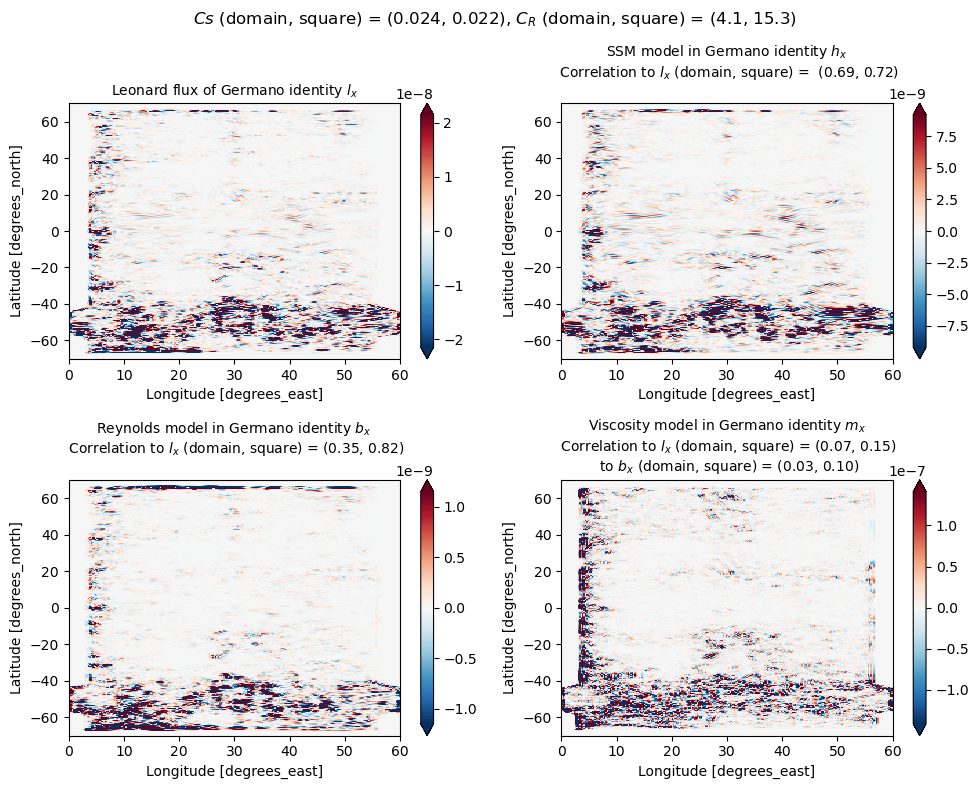

In [87]:
plot_terms_x(dyn_GID_domain, dyn_GID_square, zl=10)

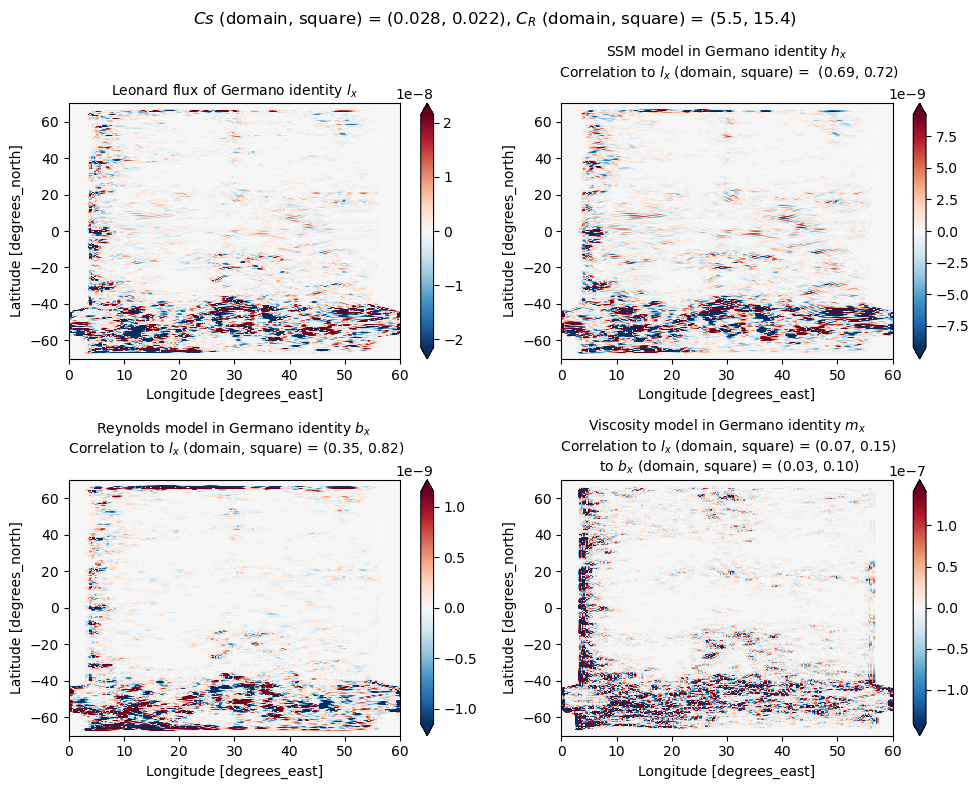

In [88]:
plot_terms_x(dyn_GIDh_domain, dyn_GIDh_square, zl=10)

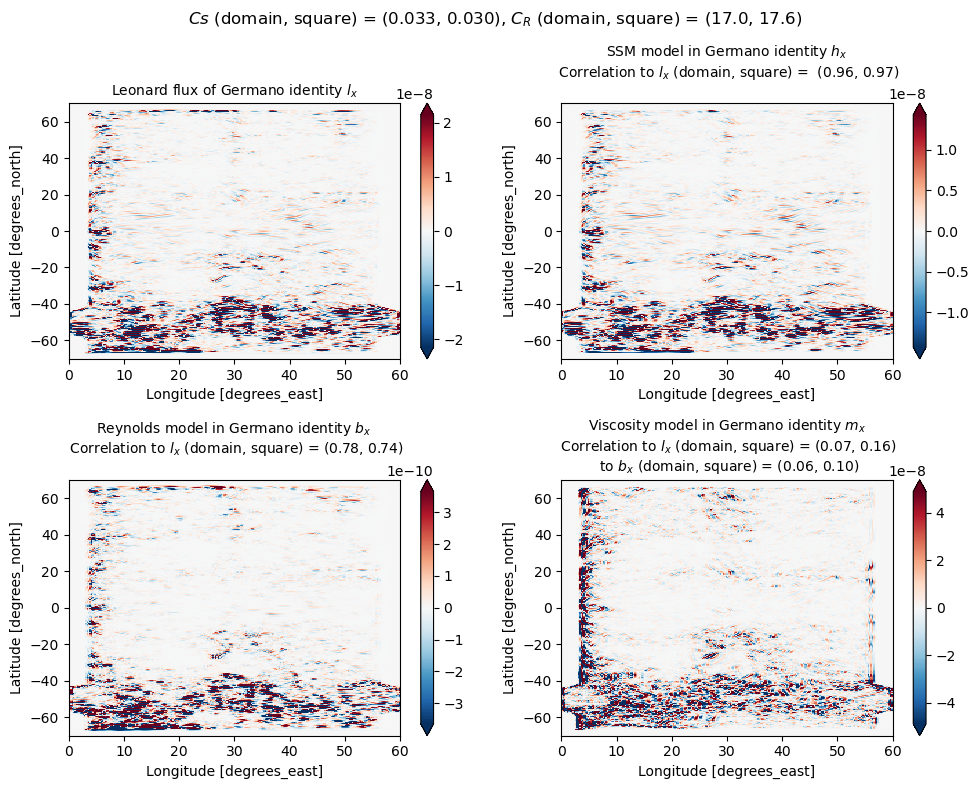

In [89]:
plot_terms_x(dyn_SSD_domain, dyn_SSD_square, zl=10)

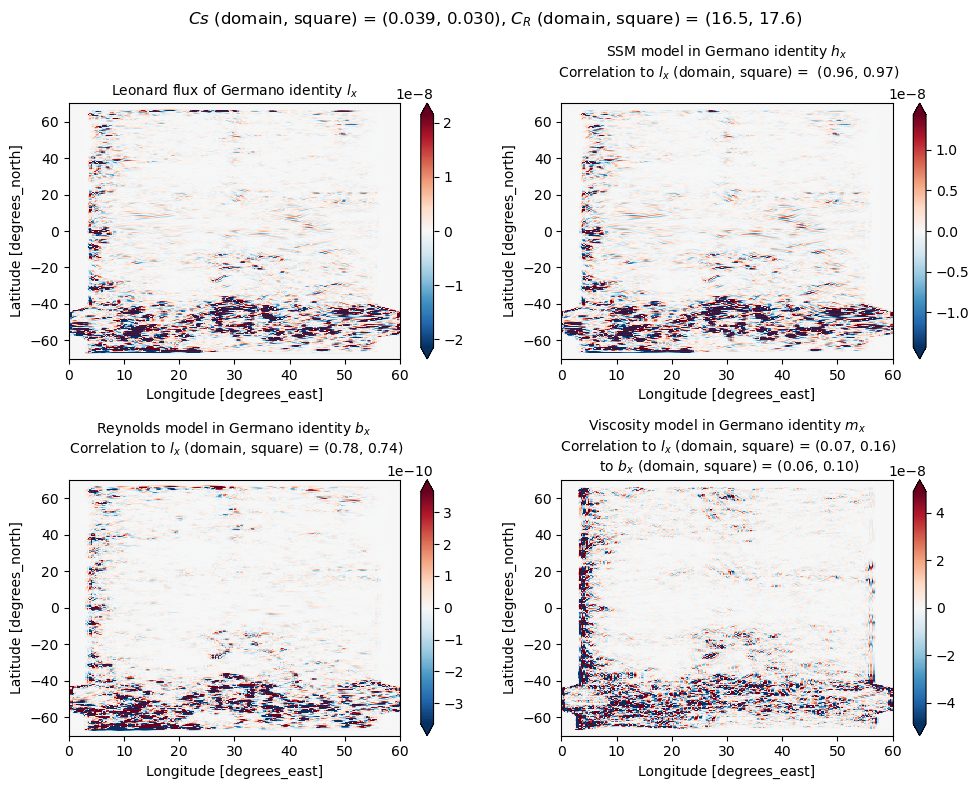

In [90]:
plot_terms_x(dyn_SSDh_domain, dyn_SSDh_square, zl=10)

# Implementation of the boundary neglection

In [143]:
from helpers.dynamic_model import filter_iteration

In [144]:
static = xr.open_dataset('/home/ctrsp-2024/pp2681/experiments/Feb2022/bare/R2/output/ocean_geometry.nc').rename({'lonq': 'xq', 'lonh': 'xh', 'latq': 'yq', 'lath': 'yh'})

In [145]:
wet0 = static.wet

In [146]:
wet1 = filter_iteration(wet0, static.wet, 'xh', 'yh',1)

In [147]:
wet2 = filter_iteration(wet0, static.wet, 'xh', 'yh',2)

In [148]:
wet3 = filter_iteration(wet0, static.wet, 'xh', 'yh',3)

In [149]:
wet4 = filter_iteration(wet0, static.wet, 'xh', 'yh',4)

In [150]:
wet10 = filter_iteration(wet0, static.wet, 'xh', 'yh',10)

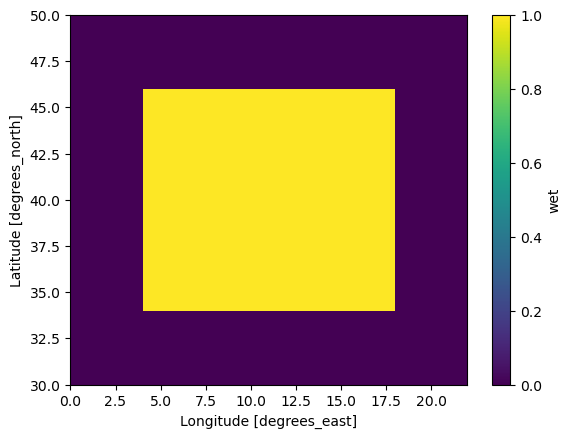

In [151]:
(wet10>0.9999).plot()

# Instability in NW2-R2

In [110]:
ds = xr.open_mfdataset('/home/ctrsp-2024/pp2681/experiments/NeverWorld2/R2/DbMM/snapshots_00000030.nc', decode_times=False)

In [114]:
def plot(idx):
    plt.figure(figsize=(12,4))
    matplotlib.rcParams.update({
        'figure.subplot.wspace': 0.3,
    })
    zl=1
    kw = {'cbar_kwargs':{'label':''}}
    plt.subplot(1,4,1)
    ds.u.isel(zl=zl, time=idx).plot(**kw)
    plt.title('u')
    plt.ylabel('')
    
    plt.subplot(1,4,2)
    ds.v.isel(zl=zl, time=idx).plot(**kw)
    plt.title('v')
    plt.ylabel('')
    
    # plt.subplot(1,4,3)
    # ds.diffu.isel(zl=zl, time=idx).plot(**kw)
    # plt.title('du/dt')
    # plt.ylabel('')
    
    # plt.subplot(1,4,4)
    # ds.diffv.isel(zl=zl, time=idx).plot(**kw)
    # plt.title('dv/dt')
    # plt.ylabel('')

In [104]:
create_animation_ffmpeg(plot, range(0,38), filename='NW2-R2-Reynolds.mp4', dpi=120, FPS=10)

Frames already exists in folder .ffmpeg/NW2-R2-Reynolds


Do you want to update snapshots?: [y/n] y


Native resolution of snapshots is used: 1222x484

Animation NW2-R2-Reynolds.mp4 at FPS=10 will last for 3.8 seconds. The frames are saved to 
.ffmpeg/NW2-R2-Reynolds

Running the command:
cd /home/ctrsp-2024/pp2681/notebooks; /home/ctrsp-2024/pp2681/ffmpeg-git-20240629-amd64-static/ffmpeg -y -framerate 10 -i .ffmpeg/NW2-R2-Reynolds/frame-%d.png -s:v 1222x484 -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p NW2-R2-Reynolds.mp4


ffmpeg version N-71064-gd5e603ddc0-static https://johnvansickle.com/ffmpeg/  Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 8 (Debian 8.3.0-6)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-debug --disable-ffplay --disable-indev=sndio --disable-outdev=sndio --cc=gcc --enable-fontconfig --enable-frei0r --enable-gnutls --enable-gmp --enable-libgme --enable-gray --enable-libaom --enable-libfribidi --enable-libass --enable-libvmaf --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librubberband --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libvorbis --enable-libopus --enable-libtheora --enable-libvidstab --enable-libvo-amrwbenc --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libdav1d --enable-libxvid --enable-libzvbi --enable-libzimg
  libavutil      59. 27.100 / 59. 27.100
  libavcodec     61.  9.100 / 61.  9.100
  

ds = xr.open_dataset('/home/ctrsp-2024/pp2681/experiments/DSM-testing/pg23*')

In [152]:
ds = xr.open_dataset('/home/ctrsp-2024/pp2681/experiments/DSM-testing/pg23__0021_001.nc')
static = xr.open_dataset('/home/ctrsp-2024/pp2681/experiments/DSM-testing/ocean_geometry.nc').rename(
    {'lonh':'xh', 'lonq':'xq', 'lath':'yh', 'latq':'yq'})

In [153]:
mask = (0.==ds.mm.isel(zl=0))

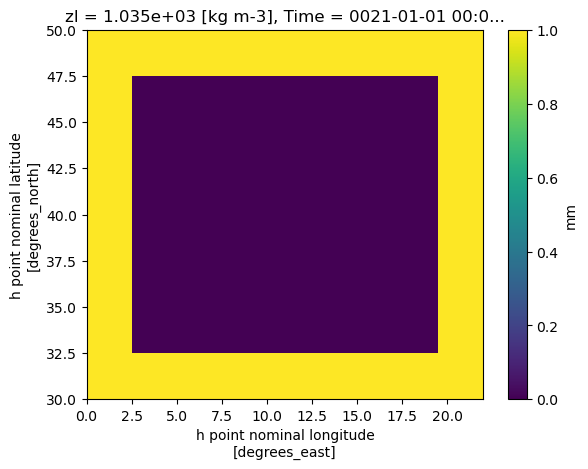

In [154]:
(0.==ds.mm.isel(zl=0)).plot()

In [161]:
mask10 = filter_iteration(static.wet, static.wet, 'xh', 'yh',10)<1

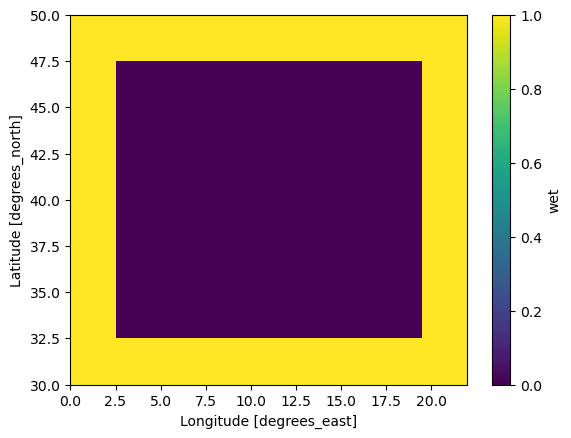

In [163]:
mask10.plot()

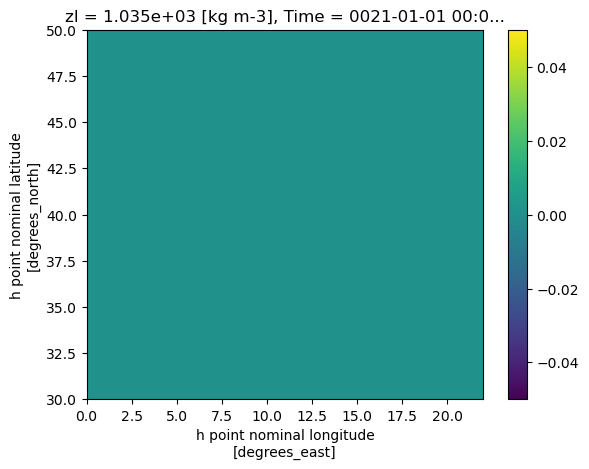

In [173]:
((mask).astype('float32')-(mask10).astype('float32')).plot()